# Audio data augmentation
## Setup

In [1]:
import os
import json

import numpy as np
import pandas as pd
import scipy.ndimage
import random

import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt

from tqdm import tqdm

/Users/sidneyma/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df_audio = pd.read_csv("audio_and_boundaries.csv")
df_audio

,word,audio,start_time,end_time
0,flag,flag.wav,0.7348,1.4830
1,zone,zone.wav,0.6710,1.4476
2,ace,ace.wav,0.7175,1.4088
3,fill,fill.wav,0.6193,1.4388
4,branch,branch.wav,0.5923,1.4690
...,...,...,...,...
195,red,red.wav,0.6319,1.5034
196,dodge,dodge.wav,0.6789,1.5185
197,mesh,mesh.wav,0.6140,1.3257
198,inch,inch.wav,0.7248,1.4729


## Custom augmentation (modification) functions

In [3]:
def amplify(audio, factor):
    return audio * factor

def noise(audio, amp): # adding white noise
    return audio + np.random.normal(0, amp, size=audio.shape)

def shift(audio, sr, seconds): # time-shifting
    samples = int(seconds * sr)
    if samples > 0:
        return np.pad(audio, (samples, 0), mode="constant")[:len(audio)]
    elif samples < 0:
        return np.pad(audio, (0, -samples), mode="constant")[-samples:]
    return audio

def stretch(audio, factor):
    stretched = scipy.ndimage.zoom(audio, 1 / factor, order=1)
    if len(stretched) > len(audio):
        return stretched[:len(audio)]
    else:
        return np.pad(stretched, (0, len(audio) - len(stretched)), mode="constant")
    
def apply_random_augmentation(audio, sr):
    gain_factor = random.uniform(0.7, 1.3)
    noise_amp = random.uniform(0.0, 0.001)
    shift_secs = random.uniform(-0.2, 0.1)
    stretch_factor = random.uniform(0.8, 1.2)

    aug = amplify(audio, gain_factor)
    aug = noise(aug, noise_amp)
    aug = shift(aug, sr, shift_secs)
    aug = stretch(aug, stretch_factor)
    # Note that shifting takes place before stretching

    # In addition to the modified signal, return the augmentation values
    return aug, {
        "gain": gain_factor,
        "noise": noise_amp,
        "shift": shift_secs,
        "stretch": stretch_factor
    }


## Main function

In [4]:
def create_augmented_dataset(df_raw, input_folder, output_folder, n_augments=9):
    rows = []

    for _, row in tqdm(df_raw.iterrows(), total=len(df_raw)):
        word = row["word"]
        base_start = row["start_time"]
        base_end = row["end_time"]

        y, sr = librosa.load(os.path.join(input_folder, row["audio"]), sr=None)

        # Original
        filename = f"{word}_0.wav"
        sf.write(os.path.join(output_folder, filename), y, sr)
        rows.append({
            **row,
            "audio": filename,
            "augment_id": 0,
            "gain": 1.0,
            "noise": 0.0,
            "shift": 0.0,
            "stretch": 1.0
        })

        # Augmented
        for i in range(1, n_augments + 1):
            y_aug, params = apply_random_augmentation(y, sr)
            
            # Adjusting start and end times
            stretch = params["stretch"]
            shift_sec = params["shift"]
            new_start = max(0.0, (base_start + shift_sec) / stretch)
            new_end = max(0.0, (base_end + shift_sec) / stretch)

            filename = f"{word}_{i}.wav"
            sf.write(os.path.join(output_folder, filename), y_aug, sr)

            rows.append({
                "word": word,
                "audio": filename,
                "augment_id": i,
                "gain": params["gain"],
                "noise": params["noise"],
                "shift": params["shift"],
                "stretch": stretch,
                "start_time": new_start,
                "end_time": new_end
            })

    return pd.DataFrame(rows)


In [5]:
raw_folder = "audio"
aug_folder = "aug_audio"
os.makedirs(raw_folder, exist_ok=True)
os.makedirs(aug_folder, exist_ok=True)

df_aug = create_augmented_dataset(df_audio, raw_folder, aug_folder, n_augments=49) # 50 samples for each audio/word
df_aug.to_csv("augmented_data.csv", index=False)
df_aug

100%|█████████████████████████████████████████| 200/200 [00:20<00:00,  9.91it/s]


,word,audio,start_time,end_time,augment_id,gain,noise,shift,stretch
0,flag,flag_0.wav,0.734800,1.483000,0,1.000000,0.000000,0.000000,1.000000
1,flag,flag_1.wav,0.617378,1.369601,1,1.170373,0.000478,-0.120724,0.994652
2,flag,flag_2.wav,0.837397,1.648270,2,1.245813,0.000029,0.037874,0.922709
3,flag,flag_3.wav,0.731869,1.405390,3,0.782524,0.000286,0.078217,1.110878
4,flag,flag_4.wav,0.817532,1.633205,4,0.766644,0.000835,0.015105,0.917279
...,...,...,...,...,...,...,...,...,...
9995,plot,plot_45.wav,0.630127,1.329961,45,1.073219,0.000566,-0.040421,1.011668
9996,plot,plot_46.wav,0.709757,1.428919,46,1.110567,0.000824,0.020840,0.984478
9997,plot,plot_47.wav,0.785457,1.550323,47,1.005573,0.000512,0.049161,0.925653
9998,plot,plot_48.wav,0.608701,1.208141,48,0.813251,0.000902,0.041038,1.181102


## Demonstration (visualizing boundaries)

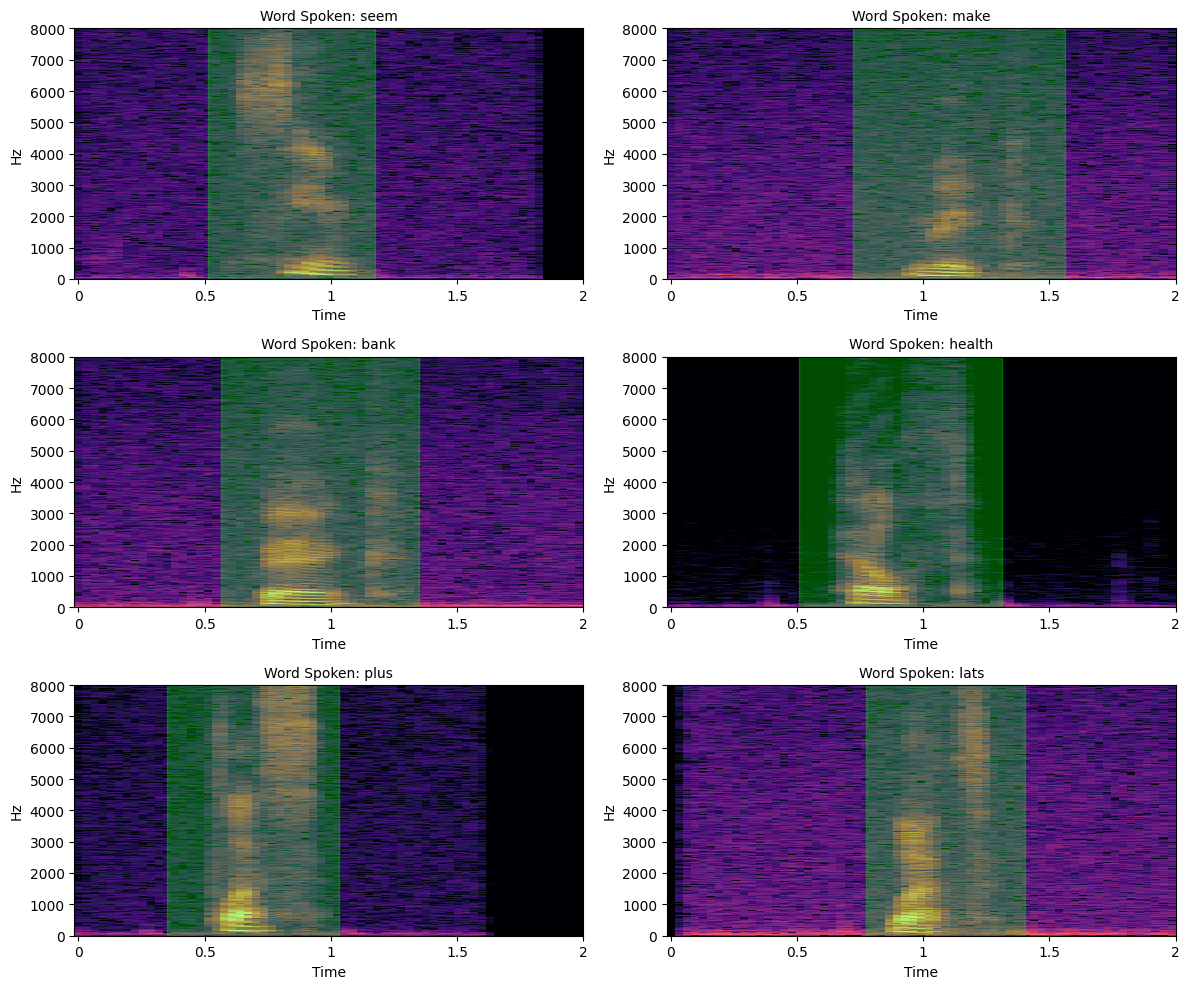

In [6]:
# Setup
words = ["seem", "make", "bank", "health", "plus", "lats"] # randomly chosen
df_aug = pd.read_csv("augmented_data.csv")

rows = []
for word in words:
    matches = df_aug[df_aug["word"] == word]
    if not matches.empty:
        rows.append(matches.sample(1).iloc[0])

# Plotting
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for i, row in enumerate(rows):
    filename = row["audio"]
    audio_path = os.path.join("aug_audio", filename)
    y, sr = librosa.load(audio_path, sr=16000)

    S = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    ax = axes[i]
    librosa.display.specshow(S, sr=sr, x_axis="time", y_axis="hz", ax=ax)

    start = row["start_time"]
    end = row["end_time"]
    ax.axvspan(start, end, color="lime", alpha=0.3)

    ax.set_title(f"Word Spoken: {row['word']}", fontsize=10)

plt.tight_layout()
plt.show()